In [1]:
import re
import os
import unicodedata
import urllib3
import zipfile
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Embedding, GRU, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

## Download the data


In [2]:
http = urllib3.PoolManager()
url ='http://www.manythings.org/anki/fra-eng.zip'
filename = 'fra-eng.zip'
path = os.getcwd()
zipfilename = os.path.join(path, filename)


with http.request('GET', url, preload_content=False) as r, open(zipfilename, 'wb') as out_file:       
    shutil.copyfileobj(r, out_file)

with zipfile.ZipFile(zipfilename, 'r') as zip_ref:
    zip_ref.extractall(path)

## Configuration


In [3]:
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
hidden_units = 256  # Latent dimensionality of the encoding space.
embedding_dim = 64
num_samples = 33000  # Number of samples to train on.

## Prepare the data


데이터셋을 다운로드한 후에 데이터를 준비하고자 다음의 단계를 수행합니다.

1. 각 문장에 start와 end 토큰을 추가합니다.
2. 특정 문자를 제거함으로써 문장을 정리합니다.
3. 단어 인덱스와 아이디(ID) 인덱스를 생성합니다. (단어 → 아이디(ID), 아이디(ID) → 단어로 매핑된 딕셔너리).
4. 각 문장을 입력층의 최대 길이만큼 패딩(padding)을 수행합니다.

In [4]:
def unicode_to_ascii(s):
  # 프랑스어 악센트(accent) 삭제
  # 예시 : 'déjà diné' -> deja dine
  return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

In [5]:
def preprocess_sentence(sent):
  # 악센트 삭제 함수 호출
  sent = unicode_to_ascii(sent.lower())

  # 단어와 구두점 사이에 공백을 만듭니다.
  # Ex) "he is a boy." => "he is a boy ."
  sent = re.sub(r"([?.!,¿])", r" \1", sent)

  # (a-z, A-Z, ".", "?", "!", ",") 이들을 제외하고는 전부 공백으로 변환합니다.
  sent = re.sub(r"[^a-zA-Z!.?]+", r" ", sent)

  # 다수 개의 공백을 하나의 공백으로 치환
  sent = re.sub(r"\s+", " ", sent)
  return sent

훈련 과정에서 교사 강요(Teacher Forcing)을 사용할 예정이므로, 훈련 시 사용할 디코더의 입력 시퀀스와 실제값. 즉, 레이블에 해당되는 출력 시퀀스를 따로 분리하여 저장합니다. 입력 시퀀스에는 시작을 의미하는 토큰인 <sos>를 추가하고, 출력 시퀀스에는 종료를 의미하는 토큰인 <eos>를 추가합니다.

- 교사 강요란? 
    - 훈련 과정에서는 이전 시점의 디코더 셀의 출력을 현재 시점의 디코더 셀의 입력으로 넣어주지 않고, 이전 시점의 실제값을 현재 시점의 디코더 셀의 입력값으로 하는 방법을 사용할 겁니다. 그 이유는 이전 시점의 디코더 셀의 예측이 틀렸는데 이를 현재 시점의 디코더 셀의 입력으로 사용하면 현재 시점의 디코더 셀의 예측도 잘못될 가능성이 높고 이는 연쇄 작용으로 디코더 전체의 예측을 어렵게 합니다. 이런 상황이 반복되면 훈련 시간이 느려집니다. 만약 이 상황을 원하지 않는다면 이전 시점의 디코더 셀의 예측값 대신 실제값을 현재 시점의 디코더 셀의 입력으로 사용하는 방법을 사용할 수 있습니다. 이와 같이 RNN의 모든 시점에 대해서 이전 시점의 예측값 대신 실제값을 입력으로 주는 방법을 교사 강요라고 합니다.

In [9]:
'dudd\t라마바\tcopyright'.split('\t')

['dudd', '라마바', 'copyright']

In [10]:
def load_preprocessed_data():
  encoder_input, decoder_input, decoder_target = [], [], []

  with open("fra.txt", "r") as lines:
    for i, line in enumerate(lines):
      # source 데이터와 target 데이터 분리
      src_line, tar_line, _ = line.strip().split('\t')

      # source 데이터 전처리
      src_line = [w for w in preprocess_sentence(src_line).split()]

      # target 데이터 전처리
      tar_line = preprocess_sentence(tar_line)
      tar_line_in = [w for w in ("<sos> " + tar_line).split()]  # teacher forcing을 위한 정답셋 
      tar_line_out = [w for w in (tar_line + " <eos>").split()]

      encoder_input.append(src_line)
      decoder_input.append(tar_line_in)
      decoder_target.append(tar_line_out)

      if i == num_samples - 1:
        break
                
  return encoder_input, decoder_input, decoder_target

In [11]:
# 전처리 테스트
en_sent = u"Have you had dinner?"
fr_sent = u"Avez-vous déjà diné?"

print('전처리 전 영어 문장 :', en_sent)
print('전처리 후 영어 문장 :',preprocess_sentence(en_sent))
print('전처리 전 프랑스어 문장 :', fr_sent)
print('전처리 후 프랑스어 문장 :', preprocess_sentence(fr_sent))

전처리 전 영어 문장 : Have you had dinner?
전처리 후 영어 문장 : have you had dinner ?
전처리 전 프랑스어 문장 : Avez-vous déjà diné?
전처리 후 프랑스어 문장 : avez vous deja dine ?


In [12]:
sents_en_in, sents_fra_in, sents_fra_out  = load_preprocessed_data()

In [13]:
print('인코더의 입력 :',sents_en_in[:5])
print('디코더의 입력 :',sents_fra_in[:5])
print('디코더의 레이블 :',sents_fra_out[:5])

인코더의 입력 : [['go', '.'], ['go', '.'], ['go', '.'], ['hi', '.'], ['hi', '.']]
디코더의 입력 : [['<sos>', 'va', '!'], ['<sos>', 'marche', '.'], ['<sos>', 'bouge', '!'], ['<sos>', 'salut', '!'], ['<sos>', 'salut', '.']]
디코더의 레이블 : [['va', '!', '<eos>'], ['marche', '.', '<eos>'], ['bouge', '!', '<eos>'], ['salut', '!', '<eos>'], ['salut', '.', '<eos>']]


단어집합을 생성하겠습니다. 

In [14]:
# 영어

tokenizer_en = Tokenizer(filters="", lower = False)
tokenizer_en.fit_on_texts(sents_en_in)
encoder_input = tokenizer_en.texts_to_sequences(sents_en_in)

In [18]:
# 프랑스어
tokenizer_fra = Tokenizer(filters="", lower = False)
tokenizer_fra.fit_on_texts(sents_fra_in)
tokenizer_fra.fit_on_texts(sents_fra_out)

decoder_input = tokenizer_fra.texts_to_sequences(sents_fra_in)
decoder_target = tokenizer_fra.texts_to_sequences(sents_fra_out)

In [21]:
decoder_target[-5:]

[[70, 5, 26, 32, 7, 8, 739, 6, 3],
 [70, 5, 26, 32, 7, 8, 431, 6, 3],
 [32, 4830, 42, 6, 3],
 [32, 4830, 48, 6, 3],
 [70, 56, 21, 620, 6, 3]]

각 문장을 입력층의 최대 길이만큼 패딩(padding)을 수행합니다. 

In [22]:
encoder_input = pad_sequences(encoder_input, padding='post')
decoder_input = pad_sequences(decoder_input, padding='post')
decoder_target = pad_sequences(decoder_target, padding='post')

In [23]:
print('인코더의 입력의 크기(shape) :',encoder_input.shape)
print('디코더의 입력의 크기(shape) :',decoder_input.shape)
print('디코더의 레이블의 크기(shape) :',decoder_target.shape)

인코더의 입력의 크기(shape) : (33000, 8)
디코더의 입력의 크기(shape) : (33000, 16)
디코더의 레이블의 크기(shape) : (33000, 16)


샘플은 총 33,000개 존재하며 영어 문장의 길이는 8, 프랑스어 문장의 길이는 16입니다. 단어 집합의 크기를 정의합니다.


In [24]:
print(tokenizer_en.word_index)
print(tokenizer_fra.word_index)

{'.': 1, 'i': 2, 'you': 3, '?': 4, 'tom': 5, 'it': 6, 'is': 7, 's': 8, 'a': 9, 're': 10, 'we': 11, 'm': 12, 't': 13, 'the': 14, 'that': 15, 'he': 16, 'was': 17, 'me': 18, 'this': 19, 'they': 20, 'to': 21, 'are': 22, '!': 23, 'do': 24, 'can': 25, 'my': 26, 'your': 27, 'have': 28, 'go': 29, 'not': 30, 'don': 31, 'll': 32, 'be': 33, 'she': 34, 'no': 35, 'what': 36, 'did': 37, 'all': 38, 'here': 39, 'let': 40, 'like': 41, 'in': 42, 'get': 43, 'up': 44, 'very': 45, 'how': 46, 'on': 47, 'need': 48, 'one': 49, 'want': 50, 'him': 51, 'out': 52, 'love': 53, 'who': 54, 'come': 55, 'there': 56, 'just': 57, 'please': 58, 'now': 59, 'us': 60, 'know': 61, 'stop': 62, 'so': 63, 'of': 64, 'got': 65, 'too': 66, 'help': 67, 'look': 68, 'take': 69, 'were': 70, 'good': 71, 'for': 72, 'has': 73, 've': 74, 'see': 75, 'at': 76, 'will': 77, 'keep': 78, 'am': 79, 'had': 80, 'back': 81, 'give': 82, 'feel': 83, 'try': 84, 'stay': 85, 'saw': 86, 'must': 87, 'happy': 88, 'home': 89, 'where': 90, 'alone': 91, 'didn

In [25]:
src_vocab_size = len(tokenizer_en.word_index) + 1
tar_vocab_size = len(tokenizer_fra.word_index) + 1

print(f"영어 단어 집합의 크기 : {src_vocab_size}, 프랑스어 단어 집합의 크기 : {tar_vocab_size}")

영어 단어 집합의 크기 : 4672, 프랑스어 단어 집합의 크기 : 8153


단어로부터 정수를 얻는 딕셔너리와 정수로부터 단어를 얻는 딕셔너리를 각각 만들어줍니다. 이들은 훈련을 마치고 예측값과 실제값을 비교하는 단계에서 사용합니다. 

In [26]:
src_to_index = tokenizer_en.word_index  # word : idx
index_to_src = tokenizer_en.index_word  # idx : word
tar_to_index = tokenizer_fra.word_index # word : idx
index_to_tar = tokenizer_fra.index_word # idx : word

In [28]:
print(src_to_index)
print(index_to_src)

{'.': 1, 'i': 2, 'you': 3, '?': 4, 'tom': 5, 'it': 6, 'is': 7, 's': 8, 'a': 9, 're': 10, 'we': 11, 'm': 12, 't': 13, 'the': 14, 'that': 15, 'he': 16, 'was': 17, 'me': 18, 'this': 19, 'they': 20, 'to': 21, 'are': 22, '!': 23, 'do': 24, 'can': 25, 'my': 26, 'your': 27, 'have': 28, 'go': 29, 'not': 30, 'don': 31, 'll': 32, 'be': 33, 'she': 34, 'no': 35, 'what': 36, 'did': 37, 'all': 38, 'here': 39, 'let': 40, 'like': 41, 'in': 42, 'get': 43, 'up': 44, 'very': 45, 'how': 46, 'on': 47, 'need': 48, 'one': 49, 'want': 50, 'him': 51, 'out': 52, 'love': 53, 'who': 54, 'come': 55, 'there': 56, 'just': 57, 'please': 58, 'now': 59, 'us': 60, 'know': 61, 'stop': 62, 'so': 63, 'of': 64, 'got': 65, 'too': 66, 'help': 67, 'look': 68, 'take': 69, 'were': 70, 'good': 71, 'for': 72, 'has': 73, 've': 74, 'see': 75, 'at': 76, 'will': 77, 'keep': 78, 'am': 79, 'had': 80, 'back': 81, 'give': 82, 'feel': 83, 'try': 84, 'stay': 85, 'saw': 86, 'must': 87, 'happy': 88, 'home': 89, 'where': 90, 'alone': 91, 'didn

테스트 데이터를 분리하겠습니다. 인코더 input, 디코더 input, 디코더 output이 동일하게 분리되어야 하기 때문에 랜덤한 정수배열을 만들어 직접 나누겠습니다. 

우선 랜덤하게 시퀀스를 섞습니다. 

In [29]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print('랜덤 시퀀스 :',indices)

랜덤 시퀀스 : [27416 14946 13630 ... 26029 32390  5506]


In [30]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [31]:
decoder_input[indices[0]], decoder_target[indices[0]]

(array([   2,    4,   20, 2278,    1,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0], dtype=int32),
 array([   4,   20, 2278,    1,    3,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0], dtype=int32))

`<sos>` `<eos>` 토큰을 제외한 다른 단어들은 동일한 인덱스를 갖고 있어야 합니다. 

10%의 데이터를 test데이터로 분리하겠습니다. 

In [32]:
n_of_val = int(num_samples*0.1)

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [33]:
print('훈련 source 데이터의 크기 :',encoder_input_train.shape)
print('훈련 target 데이터의 크기 :',decoder_input_train.shape)
print('훈련 target 레이블의 크기 :',decoder_target_train.shape)
print('테스트 source 데이터의 크기 :',encoder_input_test.shape)
print('테스트 target 데이터의 크기 :',decoder_input_test.shape)
print('테스트 target 레이블의 크기 :',decoder_target_test.shape)

훈련 source 데이터의 크기 : (29700, 8)
훈련 target 데이터의 크기 : (29700, 16)
훈련 target 레이블의 크기 : (29700, 16)
테스트 source 데이터의 크기 : (3300, 8)
테스트 target 데이터의 크기 : (3300, 16)
테스트 target 레이블의 크기 : (3300, 16)


## 모델링

### Build the model - Functional API


지금까지 사용했던 Sequential의 경우, Sequential 인스턴스를 생성한 후 해당 인스턴스에 여러 레어이를 순차적으로 더하기만 하면 모델이 완성되었습니다. 그런데 모델이 순차적이지 않다면 어떻게 모델을 빌드해야 할까요?

방법1. Functional API 사용하기    
방법2. Custom layer or Custom Model 만들기   

Tensorflow 모델 빌드하기 
- keras Model : https://www.tensorflow.org/api_docs/python/tf/keras/Model
- keras Input : https://www.tensorflow.org/api_docs/python/tf/keras/Input


- With the "Functional API", where you start from `Input`, you chain layer calls to specify the model's forward pass, and finally you create your model from `inputs` and `outputs`

- `Model` groups layers into an object with training and inference features.
- `Input()` is used to instantiate a Keras tensor.

이제 번역기를 빌드해보겠습니다. 

In [34]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Masking
from tensorflow.keras.models import Model

In [35]:
import tensorflow as tf 

inputs = tf.keras.Input(shape=(3, ))
x = tf.keras.layers.Dense(4, activation = tf.nn.relu)(inputs)
outputs = tf.keras.layers.Dense(5, activation = tf.nn.softmax)(x)

model = tf.keras.Model(inputs=inputs, outputs = outputs)
model

In [36]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 3)]               0         
                                                                 
 dense (Dense)               (None, 4)                 16        
                                                                 
 dense_1 (Dense)             (None, 5)                 25        
                                                                 
Total params: 41
Trainable params: 41
Non-trainable params: 0
_________________________________________________________________


### 번역기 설계

인코더를 설계합니다. LSTM에서 state_h, state_c를 리턴받는데, 이는 각각 RNN 챕터에서 LSTM을 처음 설명할 때 언급하였던 은닉 상태와 셀 상태에 해당됩니다. 이 두 가지 상태를 encoder_states에 저장합니다. encoder_states를 디코더에 전달하므로서 이 두 가지 상태 모두를 디코더로 전달할 예정입니다. 이것이 앞서 배운 컨텍스트 벡터입니다.

In [39]:
from tensorflow.keras.layers import Input

# 인코더
encoder_inputs = Input(shape=(None, ))

# 임베딩 층
enc_emb = Embedding(src_vocab_size, embedding_dim)(encoder_inputs)

# 상태값 리턴을 위해 return_state는 True
encoder_lstm = LSTM(hidden_units, return_state = True)

# 은닉 상태와 셀 상태를 리턴
encoder_outputs, state_h, state_c =  encoder_lstm(enc_emb)

encoder_states = [state_h, state_c] # 인코더의 은닉 상태와 셀 상태를 저장

디코더는 인코더의 마지막 은닉 상태로부터 초기 은닉 상태를 얻습니다. initial_state의 인자값으로 encoder_states를 주는 코드가 이에 해당됩니다. 디코더도 은닉 상태, 셀 상태를 리턴하기는 하지만 훈련 과정에서는 사용하지 않습니다. seq2seq의 디코더는 기본적으로 각 시점마다 다중 클래스 분류 문제를 풀고있습니다. 매 시점마다 프랑스어 단어 집합의 크기(tar_vocab_size)의 선택지에서 단어를 1개 선택하여 이를 이번 시점에서 예측한 단어로 택합니다. 다중 클래스 분류 문제이므로 출력층으로 소프트맥스 함수와 손실 함수를 크로스 엔트로피 함수를 사용합니다.

categorical_crossentropy를 사용하려면 레이블은 원-핫 인코딩이 된 상태여야 합니다. 그런데 현재 decoder_outputs의 경우에는 원-핫 인코딩을 하지 않은 상태입니다. 원-핫 인코딩을 하지 않은 상태로 정수 레이블에 대해서 다중 클래스 분류 문제를 풀고자 하는 경우에는 categorical_crossentropy가 아니라 sparse_categorical_crossentropy를 사용하면 됩니다.

In [41]:
# 디코더
decoder_inputs = Input(shape=(None, ))

# 임베딩 층
dec_emb_layer = Embedding(tar_vocab_size, hidden_units)

# 임베딩 결과
dec_emb = dec_emb_layer(decoder_inputs)

# 상태값 리턴을 위해 return_state는 True, 모든 시점에 대해서 단어를 예측하기 위해 return_sequences는 True
decoder_lstm = LSTM(hidden_units, return_sequences=True, return_state = True)

# 인코더의 은닉 상태를 초기 은닉 상태(initial_state)로 사용
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = encoder_states)

# 모든 시점의 결과에 대해서 소프트맥스 함수를 사용한 출력층을 통해 단어 예측
decoder_dense = Dense(tar_vocab_size, activation = 'softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [42]:
# 모델의 입력과 출력을 정의.
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['acc'])

In [47]:
model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, 
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size=128, epochs=50)

Epoch 1/50
233/233 [==============================] - 9s 39ms/step - loss: 2.2974 - acc: 0.6776 - val_loss: 1.6583 - val_acc: 0.7471
Epoch 2/50
233/233 [==============================] - 8s 35ms/step - loss: 1.5573 - acc: 0.7509 - val_loss: 1.4721 - val_acc: 0.7616
Epoch 3/50
233/233 [==============================] - 8s 35ms/step - loss: 1.3882 - acc: 0.7698 - val_loss: 1.3296 - val_acc: 0.7795
Epoch 4/50
233/233 [==============================] - 8s 36ms/step - loss: 1.2445 - acc: 0.7904 - val_loss: 1.2234 - val_acc: 0.7999
Epoch 5/50
233/233 [==============================] - 8s 36ms/step - loss: 1.1318 - acc: 0.8055 - val_loss: 1.1406 - val_acc: 0.8107
Epoch 6/50
233/233 [==============================] - 8s 35ms/step - loss: 1.0358 - acc: 0.8169 - val_loss: 1.0700 - val_acc: 0.8206
Epoch 7/50
233/233 [==============================] - 8s 35ms/step - loss: 0.9574 - acc: 0.8274 - val_loss: 1.0245 - val_acc: 0.8276
Epoch 8/50
233/233 [==============================] - 8s 36ms/step - 

In [44]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, None, 64)     299008      ['input_3[0][0]']                
                                                                                                  
 embedding_3 (Embedding)        (None, None, 256)    2087168     ['input_5[0][0]']                
                                                                                            

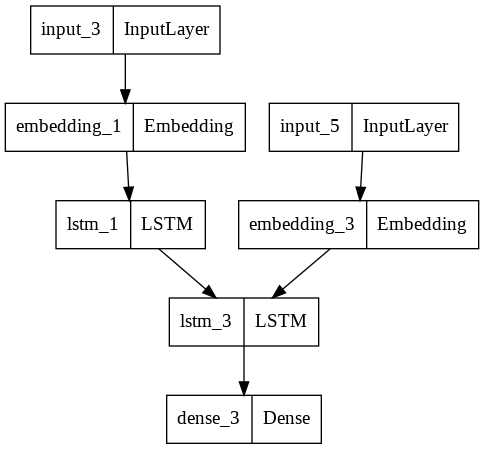

In [46]:
tf.keras.utils.plot_model(model, to_file='model.png', )

## 훈련된 모델로 번역하기

* 평가 함수는 여기서 *교사 강요(teacher forcing)*를 사용하기 못하는 것을 제외하고는 훈련 루프와 비슷합니다. 각 마지막 시점(time step)에서 이전 디코더 인코더의 결과와 은닉 상태(hidden state)를 가진 예측 값을 디코더에 입력합니다.

    1. 번역하고자 하는 입력 문장이 인코더로 입력되어 인코더의 마지막 시점의 은닉 상태와 셀 상태를 얻습니다.
    2. 인코더의 은닉 상태와 셀 상태, 그리고 토큰 <sos>를 디코더로 보냅니다.
    3. 디코더가 토큰 <eos>가 나올 때까지 다음 단어를 예측하는 행동을 반복합니다.

In [54]:
# 인코더 - 훈련과 동일 
encoder_model = Model(encoder_inputs, encoder_states)

In [55]:
# 디코더 

# 이전 시점의 상태를 보관할 텐서
decoder_state_input_h = Input(shape=(hidden_units,))
decoder_state_input_c = Input(shape=(hidden_units,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

# 훈련 때 사용했던 임베딩 층을 재사용
dec_emb2 = dec_emb_layer(decoder_inputs)

# 다음 단어 예측을 위해 이전 시점의 상태를 현 시점의 초기 상태로 사용
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=decoder_states_inputs)
decoder_states2 = [state_h2, state_c2]

# 모든 시점에 대해서 단어 예측 (Fully Connected)
decoder_outputs2 = decoder_dense(decoder_outputs2)

# 수정된 디코더
decoder_model = Model(
    [decoder_inputs] + decoder_states_inputs,
    [decoder_outputs2] + decoder_states2)

테스트 단계에서의 동작을 위한 decode_sequence 함수를 구현합니다. 
1. 입력 문장이 들어오면 인코더는 마지막 시점까지 전개하여 마지막 시점의 은닉 상태와 셀 상태를 리턴합니다. -> `states_value` 
2. 디코더의 초기 입력으로 <SOS>를 준비합니다. -> `target_seq`
3. 이 두 가지 입력을 가지고 while문 안으로 진입하여 이 두 가지를 디코더의 입력으로 사용합니다. 
4. 이제 디코더는 현재 시점에 대해서 예측합니다. 
    - 예측 벡터로부터 현재 시점의 예측 단어인 target_seq를 얻고, h와 c 이 두 개의 값은 states_value에 저장합니다. 
    - while문의 다음 루프. 즉, 두번째 시점의 디코더의 입력으로 다시 target_seq와 states_value를 사용합니다. 
    - 이를 현재 시점의 예측 단어로 <eos>를 예측하거나 번역 문장의 길이가 50이 넘는 순간까지 반복합니다. 
5. 각 시점마다 번역된 단어는 decoded_sentence에 누적하여 저장하였다가 최종 번역 시퀀스로 리턴합니다.

In [56]:
def decode_sequence(input_seq):
  # 입력으로부터 인코더의 마지막 시점의 상태(은닉 상태, 셀 상태)를 얻음
  states_value = encoder_model.predict(input_seq)

  # <SOS>에 해당하는 정수 생성
  target_seq = np.zeros((1,1))
  target_seq[0, 0] = tar_to_index['<sos>']

  stop_condition = False
  decoded_sentence = ''

  # stop_condition이 True가 될 때까지 루프 반복
  # 구현의 간소화를 위해서 이 함수는 배치 크기를 1로 가정합니다.
  while not stop_condition:
    # 이점 시점의 상태 states_value를 현 시점의 초기 상태로 사용
    output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

    # 예측 결과를 단어로 변환
    sampled_token_index = np.argmax(output_tokens[0, -1, :])
    sampled_char = index_to_tar[sampled_token_index]

    # 현재 시점의 예측 단어를 예측 문장에 추가
    decoded_sentence += ' '+sampled_char

    # <eos>에 도달하거나 정해진 길이를 넘으면 중단.
    if (sampled_char == '<eos>' or
        len(decoded_sentence) > 50):
        stop_condition = True

    # 현재 시점의 예측 결과를 다음 시점의 입력으로 사용하기 위해 저장
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = sampled_token_index

    # 현재 시점의 상태를 다음 시점의 상태로 사용하기 위해 저장
    states_value = [h, c]

  return decoded_sentence

결과 확인을 위한 함수를 만듭니다.

In [57]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_src(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0):
      sentence = sentence + index_to_src[encoded_word] + ' '
  return sentence

# 번역문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq_to_tar(input_seq):
  sentence = ''
  for encoded_word in input_seq:
    if(encoded_word != 0 and encoded_word != tar_to_index['<sos>'] and encoded_word != tar_to_index['<eos>']):
      sentence = sentence + index_to_tar[encoded_word] + ' '
  return sentence

In [58]:
for seq_index in [3, 50, 100, 300, 1001]:
  input_seq = encoder_input_train[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("입력문장 :",seq_to_src(encoder_input_train[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_train[seq_index]))
  print("번역문장 :",decoded_sentence[1:-5])
  print("-"*50)

입력문장 : let go of my hair . 
정답문장 : lache moi les cheveux ! 
번역문장 : lache moi les cheveux ! 
--------------------------------------------------
입력문장 : i ve heard enough . 
정답문장 : j en ai assez entendu . 
번역문장 : j en ai assez entendu . 
--------------------------------------------------
입력문장 : that sounds great . 
정답문장 : ca a l air super ! 
번역문장 : ca a l air super ! 
--------------------------------------------------
입력문장 : what do you know ? 
정답문장 : que sais tu ? 
번역문장 : que savez vous ? 
--------------------------------------------------
입력문장 : i m in love . 
정답문장 : je suis amoureux . 
번역문장 : je suis amoureux . 
--------------------------------------------------


In [59]:
for seq_index in [3, 50, 100, 300, 1001]:
  input_seq = encoder_input_test[seq_index: seq_index + 1]
  decoded_sentence = decode_sequence(input_seq)

  print("입력문장 :",seq_to_src(encoder_input_test[seq_index]))
  print("정답문장 :",seq_to_tar(decoder_input_test[seq_index]))
  print("번역문장 :",decoded_sentence[1:-5])
  print("-"*50)

입력문장 : you re too loud . 
정답문장 : vous etes trop bruyant . 
번역문장 : vous etes trop bruyante . 
--------------------------------------------------
입력문장 : we prayed together . 
정답문장 : nous avons prie ensemble . 
번역문장 : nous nous entrainons ensemble . 
--------------------------------------------------
입력문장 : hurry up . 
정답문장 : depeche toi . 
번역문장 : magne toi ! 
--------------------------------------------------
입력문장 : lock the safe . 
정답문장 : fermez le coffre . 
번역문장 : ferme le coffre . 
--------------------------------------------------
입력문장 : i want that . 
정답문장 : je le veux . 
번역문장 : je veux ceci . 
--------------------------------------------------


## BLEU Score (Bilingual Evaluation Understudy Score)
기계 번역의 성능이 얼마나 뛰어난가를 측정하기 위해 사용되는 대표적인 방법 중 하나인 BLEU(Bilingual Evaluation Understudy)를 측정해봅시다. 
- 논문 : BLEU: a Method for Automatic Evaluation of Machine Translation
- BLEU 점수는 기계 번역된 텍스트와 고품질 참조 번역 세트의 유사성을 측정하는 0과 1 사이의 숫자입니다. 
    - 값이 0이면 기계 번역된 출력이 참조 번역과 겹치는 부분이 없는 것을 의미하고(저품질)
    - 1이면 참조 번역과 완벽하게 겹치는 것을 의미합니다(고품질)

- BLEU 설명 
    - https://jrc-park.tistory.com/273
    - https://wikidocs.net/31695
    - https://cloud.google.com/translate/automl/docs/evaluate?hl=ko#bleu

In [60]:
import numpy as np
from collections import Counter
from nltk import ngrams

BLEU는 기계 번역 결과와 사람이 직접 번역한 결과가 얼마나 유사한지 비교하여 번역에 대한 성능을 측정하는 방법입니다. 

In [61]:
import nltk.translate.bleu_score as bleu

candidate = 'It is a guide to action which ensures that the military always obeys the commands of the party'
references = [
    'It is a guide to action that ensures that the military will forever heed Party commands',
    'It is the guiding principle which guarantees the military forces always being under the command of the Party',
    'It is the practical guide for the army always to heed the directions of the party'
]

print('패키지 NLTK의 BLEU :',bleu.sentence_bleu(list(map(lambda ref: ref.split(), references)),candidate.split()))

패키지 NLTK의 BLEU : 0.5045666840058485


In [63]:
ref_train = [seq_to_tar(sen) for sen in decoder_input_train[:100]]

In [65]:
from tqdm.notebook import tqdm 

pred_train = []
for idx in tqdm(range(len(encoder_input_train[:100]))):
    pred_train.append(decode_sequence(encoder_input_train[idx:idx+1]))

  0%|          | 0/100 [00:00<?, ?it/s]

In [67]:
bleu_score = 0
for ref, pred in zip(ref_train, pred_train):
    if len(ref) == 0 or len(pred) == 0:
        continue
    bleu_score += bleu.sentence_bleu(ref, pred)

bleu_score = bleu_score/len(ref_train)
bleu_score

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.794948539930212

In [68]:
ref_test = [seq_to_tar(sen) for sen in decoder_input_test[:100]]
pred_test = [decode_sequence(encoder_input_test[idx:idx+1]) for idx in tqdm(range(len(encoder_input_test[:100])))]

bleu_score = 0
for ref, pred in zip(ref_test, pred_test):
    if len(ref) == 0 or len(pred) == 0:
        continue
    bleu_score += bleu.sentence_bleu(ref, pred)

bleu_score = bleu_score/len(ref_test)
bleu_score

  0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


0.7681095562362286

### Reference

- https://blog.keras.io/a-ten-minute-introduction-to-sequence-to-sequence-learning-in-keras.html
- https://wikidocs.net/86900